In [ ]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.linalg import norm

In [ ]:
# Load in housing datasets
df1 = pd.read_csv('medianAskingPrice_All.csv')
df2 = pd.read_csv('medianAskingRent_All.csv')
df3 = pd.read_csv('recordedSalesVolume_All.csv')
df4 = pd.read_csv('daysOnMarket_All.csv')
df5 = pd.read_csv('saleListRatio_All.csv')
df6 = pd.read_csv('medianSalesPrice_All.csv')

# Make Data replicable
random.seed(6)

# Exploratory Data Analysis

## Data Visualization

In [ ]:
df1

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02
0,All Downtown,Manhattan,submarket,1399000.0,1395000.0,1322500.0,1295000.0,1265000.0,1225000.0,1188000.0,...,1995000.0,1995000.0,1995000.0,1995000.0,1995000.0,1995000.0,1999999.0,2135000.0,2165000.0,2005000.0
1,All Midtown,Manhattan,submarket,895000.0,885000.0,899000.0,895000.0,882500.0,887250.0,875000.0,...,1249500.0,1200000.0,1200000.0,1250000.0,1280000.0,1280000.0,1299000.0,1348000.0,1355000.0,1350000.0
2,All Upper East Side,Manhattan,submarket,1200000.0,1195000.0,1185000.0,1195000.0,1100000.0,1129000.0,1100000.0,...,1697000.0,1750000.0,1750000.0,1782500.0,1800000.0,1850000.0,1850000.0,1895000.0,1895000.0,1895000.0
3,All Upper Manhattan,Manhattan,submarket,539000.0,537600.0,525000.0,525000.0,499000.0,499000.0,499000.0,...,695000.0,699000.0,690000.0,687500.0,650000.0,699000.0,699000.0,699000.0,719000.0,700000.0
4,All Upper West Side,Manhattan,submarket,1050000.0,1060000.0,1063519.0,999000.0,1040000.0,998000.0,999000.0,...,1595000.0,1595000.0,1592500.0,1595000.0,1595000.0,1595000.0,1675000.0,1695000.0,1790000.0,1798000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Windsor Terrace,Brooklyn,neighborhood,614000.0,629000.0,575000.0,549000.0,575000.0,575000.0,594000.0,...,1225000.0,1200000.0,1200000.0,950000.0,1211500.0,1499000.0,1395000.0,1450000.0,1274500.0,1187500.0
194,Woodhaven,Queens,neighborhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,749000.0,775000.0,762444.0,789000.0,789000.0,809999.0,846500.0,827500.0,847500.0,875000.0
195,Woodlawn,Bronx,neighborhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,Woodside,Queens,neighborhood,285000.0,287000.0,285000.0,255000.0,272000.0,289000.0,255000.0,...,550000.0,561500.0,579600.0,538000.0,517500.0,598000.0,554000.0,569000.0,598000.0,658000.0


Map:

In [ ]:
import folium
from geopy.geocoders import Nominatim
from IPython.display import IFrame

# Copy original dataset
asking_rent = df6[['areaName', 'Borough', '2024-02']]
asking_rent = asking_rent.drop(labels = [0, 1, 2, 3, 4, 126], axis = 0).reset_index(drop = True)
asking_rent['location'] = asking_rent['areaName'] + ', New York City'

# Initialize geocoder
geolocator = Nominatim(user_agent="shaneracey3@gmail.com", timeout=10)

# Function to geocode area names to get coordinates
def geocode_area(area):
    location = geolocator.geocode(area)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Geocode area names to get coordinates
asking_rent["Latitude"], asking_rent["Longitude"] = zip(*asking_rent["location"].apply(geocode_area))

# Replace missing NaN with median rent
median_rental_price = asking_rent['2024-02'].median()
asking_rent['2024-02'].fillna(median_rental_price, inplace=True)

# Drop rows with missing coordinates
rental_data = asking_rent.dropna(subset=["Latitude", "Longitude"])

# Create a map centered around NYC
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add markers for each location with popup showing rental price
for index, row in rental_data.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"${row['2024-02']} (February Rent)",
        tooltip=row["areaName"]
    ).add_to(map_nyc)

    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        icon=folium.DivIcon(html=f"<div>{row['areaName']}</div>")
    ).add_to(map_nyc)

# Display the map
map_nyc.save("nyc_rental_prices.html")

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Create a choropleth map
fig = px.scatter_mapbox(
    rental_data,
    lat="Latitude",
    lon="Longitude",
    color="2024-02",
    size="2024-02",
    hover_name="areaName",
    hover_data={"2024-02": True, "areaName": False},
    zoom=10,
    color_continuous_scale=px.colors.cyclical.mrybm,
    center={"lat": 40.7128, "lon": -74.0060},
    mapbox_style="carto-positron",
    opacity=0.5,
    labels={'2024-02':'February Sales Price'},
    title='NYC Sales Prices in February 2024'
)

# Show the map
fig.show()

In [ ]:
# Find the stats of last month by borough
mini = df6[['Borough', '2024-02']]
mini = mini.drop(labels = [0, 1, 2, 3, 4, 126], axis = 0).reset_index(drop = True)
stats = mini.groupby(['Borough']).mean().round()
stats

,2024-02
Borough,
Bronx,529600.0
Brooklyn,1010506.0
Manhattan,1095807.0
Queens,612495.0
Staten Island,305800.0


In [ ]:
# By borough
mini_df = mini.pivot(columns = 'Borough')
mini_df.describe().round()

2024-02                                              
Borough     Bronx   Brooklyn  Manhattan    Queens Staten Island
count         5.0       24.0       16.0      27.0           1.0
mean     529600.0  1010506.0  1095807.0  612495.0      305800.0
std      224611.0   362997.0   355024.0  207040.0           NaN
min      259000.0   473373.0   480000.0  255000.0      305800.0
25%      335000.0   789441.0   899375.0  458250.0      305800.0
50%      574000.0   973750.0  1023750.0  575000.0      305800.0
75%      730000.0  1149125.0  1266312.0  769167.0      305800.0
max      750000.0  1850000.0  1912500.0  996500.0      305800.0

Line graph:

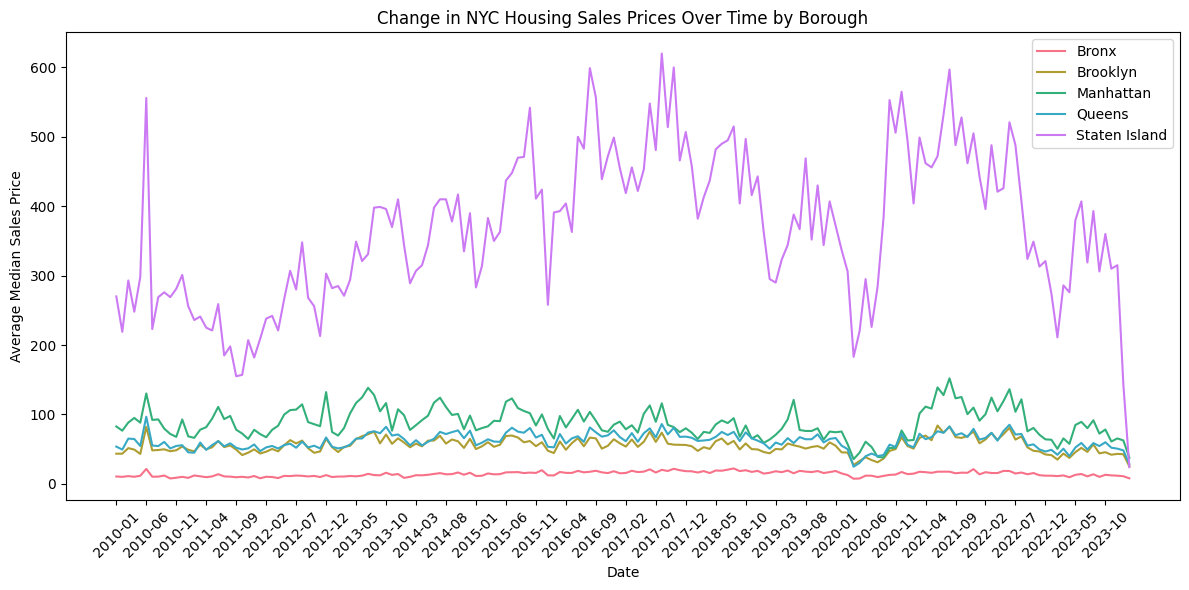

In [ ]:
df3 = df3.drop('areaType', axis=1)
subset_df3 = df3.iloc[:, 1:]
borough_avg_prices = subset_df3.groupby('Borough').mean()
# Transpose the DataFrame so that boroughs are on rows and dates are on columns
borough_avg_prices = borough_avg_prices.transpose()

# Plotting
plt.figure(figsize=(12, 6))

# Assigning different colors for each borough
colors = sns.color_palette('husl', n_colors=len(borough_avg_prices.columns))

# Plot each borough's average price over time
for i, (borough, color) in enumerate(zip(borough_avg_prices.columns, colors)):
    plt.plot(borough_avg_prices.index, borough_avg_prices[borough], label=borough, color=color)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Average Median Sales Price')
plt.title('Change in NYC Housing Sales Prices Over Time by Borough')
h = [i for i in range(0, 170) if i % 5 == 0]
plt.xticks(h, rotation=45)
plt.legend()
# Show plot
plt.tight_layout()
plt.show()

## Data Cleaning and Missing Data

In [ ]:
print("NA in df1:", df1.isna().sum().sum())
print(df1.shape)
print("NA in df2:", df2.isna().sum().sum())
print(df2.shape)
print("NA in df3:", df3.isna().sum().sum())
print(df3.shape)
print("NA in df4:", df4.isna().sum().sum())
print(df4.shape)
print("NA in df5:", df5.isna().sum().sum())
print(df5.shape)
print("NA in df6:", df6.isna().sum().sum())
print(df6.shape)

NA in df1: 9583
(198, 173)
NA in df2: 11989
(198, 173)
NA in df3: 1
(198, 173)
NA in df4: 23654
(198, 173)
NA in df5: 25157
(198, 173)
NA in df6: 12595
(198, 173)


In [ ]:
def clean_data(df, id_columns, drop_threshold=0.5, interval=2):
    """
    Cleans the provided DataFrame by removing rows with excessive NaN values and
    filling remaining NaNs using median values from nearby years within a specified interval.

    Parameters:
    - df (pd.DataFrame): The DataFrame to clean.
    - id_columns (list): List of column names that identify non-time-series data (e.g., area names, IDs).
    - drop_threshold (float): Proportion of NaNs in a row (excluding id_columns) beyond which the row is dropped.
    - interval (int): The number of years before and after the current year to consider for median calculation.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """

    # Copy the DataFrame to avoid changing the original
    df = df.copy()

    # Drop rows where id columns have NaN values
    #df.dropna(subset=id_columns, inplace=True)

    # Drop rows with excessive NaN values (excluding the ID columns)
    for index, row in df.iterrows():
        nan_count = row.drop(id_columns).isna().sum()
        num_columns = len(row) - len(id_columns)
        if nan_count > num_columns * drop_threshold:
            df.drop(index, inplace=True)

    # Fill remaining NaNs using the median value across a specified interval for each time-series column
    def fill_with_median(row):
        non_id_values = row.drop(labels=id_columns).apply(pd.to_numeric, errors='coerce')
        median_value = np.nanmedian(non_id_values.values)
        for col in non_id_values.index:
            if pd.isna(row[col]):
                row[col] = median_value
        return row

    df = df.apply(fill_with_median, axis=1)
    df.loc[df['areaName'] == 'NYC', 'Borough'] = 'Manhattan'

    for index, row in df.iterrows():
      if df.loc[index, 'Borough'] == 'Bronx':
        df.loc[index, 'Borough']= 0
      elif df.loc[index, 'Borough'] == 'Brooklyn':
        df.loc[index, 'Borough'] = 1
      elif df.loc[index, 'Borough'] == 'Manhattan':
        df.loc[index, 'Borough'] = 2
      elif df.loc[index, 'Borough'] == 'Queens':
        df.loc[index, 'Borough'] = 3
      elif df.loc[index, 'Borough'] == 'Staten Island':
        df.loc[index, 'Borough'] = 4

    return df

In [ ]:
#Clean datasets df1..df6
df1 = clean_data(df1, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df1:", df1.isna().sum().sum())
print(df1.shape)

df2 = clean_data(df2, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df2:", df2.isna().sum().sum())
print(df2.shape)

df3 = clean_data(df3, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df3:", df3.isna().sum().sum())
print(df3.shape)

df4 = clean_data(df4, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df4:", df4.isna().sum().sum())
print(df4.shape)

df5 = clean_data(df5, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df5:", df5.isna().sum().sum())
print(df5.shape)

df6 = clean_data(df6, id_columns=['areaName', 'Borough'], drop_threshold=0.5, interval=2)
print("NA in cleaned df6:", df6.isna().sum().sum())
print(df6.shape)

NA in cleaned df1: 0
(146, 173)
NA in cleaned df2: 0
(131, 173)
NA in cleaned df3: 0
(198, 173)
NA in cleaned df4: 0
(56, 173)
NA in cleaned df5: 0
(53, 173)
NA in cleaned df6: 0
(125, 173)


In [ ]:
#df1['Borough'].nunique()

Merge data to create combined dataframe with all 5 features from a particular date. We repeat this process to generate multiple dataframes using random generated column indexes (randomly chosen dates).

In [ ]:
def build_df(df1, df2, df3, df4, df5, df6, col_index):
  new_df = pd.DataFrame(index = df1['areaName'],
                     columns = ['Borough',
                               # 'areaType',
                                'MedianAskingPrice',
                                'MedianAskingRent',
                                'RecordedSalesVolume',
                                'DaysOnMarket',
                                'SaleListRatio',
                                'MedianSalesPrice'])

  new_df['Borough'] = df1.set_index('areaName')['Borough']
  #new_df['areaType'] = df1.set_index('areaName')['areaType']
  new_df['MedianAskingPrice'] = df1.set_index('areaName').iloc[:,col_index]
  new_df['MedianAskingRent'] = df2.set_index('areaName').iloc[:,col_index]
  new_df['RecordedSalesVolume'] = df3.set_index('areaName').iloc[:,col_index]
  new_df['DaysOnMarket'] = df4.set_index('areaName').iloc[:,col_index]
  new_df['SaleListRatio'] = df5.set_index('areaName').iloc[:,col_index]
  new_df['MedianSalesPrice'] = df6.set_index('areaName').iloc[:,col_index]

  for index, row in new_df.iterrows():
    if row.isna().sum()>0:
      new_df.drop(index, inplace=True)

  return new_df

In [ ]:
#df1.shape
#data1 = build_df(df1, df2, df3, df4, df5, df6, 171)
#data1

# Model Selection

In [ ]:
random.seed(6)

Least Squares Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     31.06
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.31e-14
Time:                        01:49:46   Log-Likelihood:                -733.57
No. Observations:                  53   AIC:                             1481.
Df Residuals:                      46   BIC:                             1495.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6.736e+05    

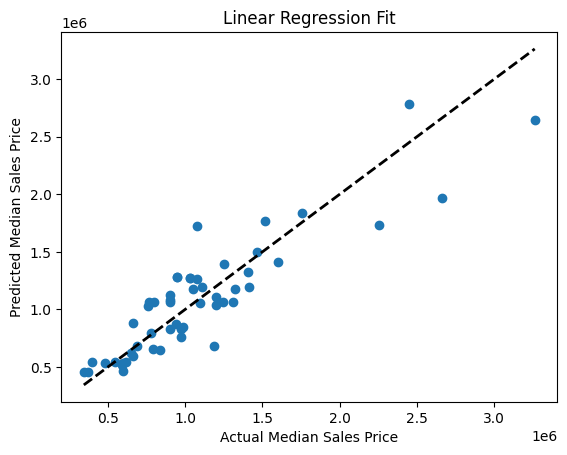

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     34.39
Date:                Mon, 13 May 2024   Prob (F-statistic):           2.03e-15
Time:                        01:49:46   Log-Likelihood:                -740.40
No. Observations:                  53   AIC:                             1495.
Df Residuals:                      46   BIC:                             1509.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.926e+06   2

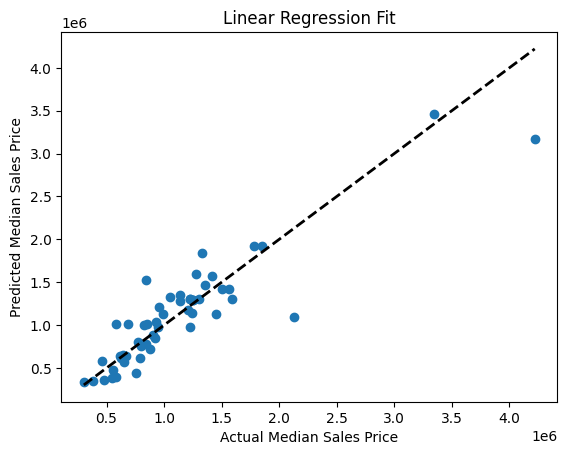

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     35.01
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.46e-15
Time:                        01:49:47   Log-Likelihood:                -729.40
No. Observations:                  53   AIC:                             1473.
Df Residuals:                      46   BIC:                             1487.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.372e+06   1

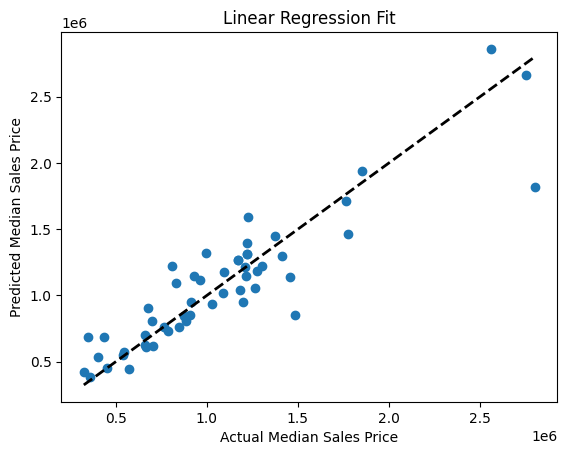

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     38.02
Date:                Mon, 13 May 2024   Prob (F-statistic):           3.13e-16
Time:                        01:49:47   Log-Likelihood:                -724.49
No. Observations:                  53   AIC:                             1463.
Df Residuals:                      46   BIC:                             1477.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.134e+06   1

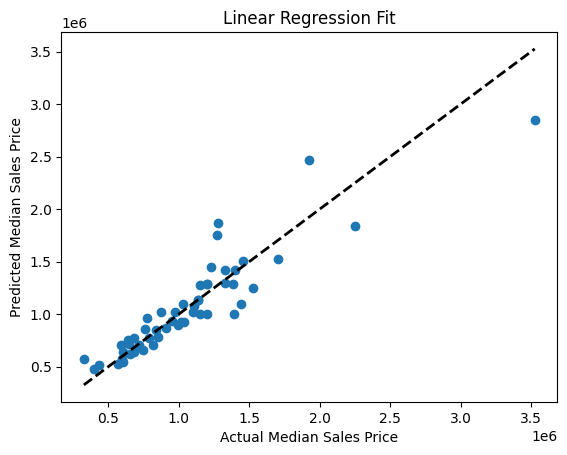

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     35.58
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.08e-15
Time:                        01:49:47   Log-Likelihood:                -745.88
No. Observations:                  53   AIC:                             1506.
Df Residuals:                      46   BIC:                             1520.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.597e+04   2

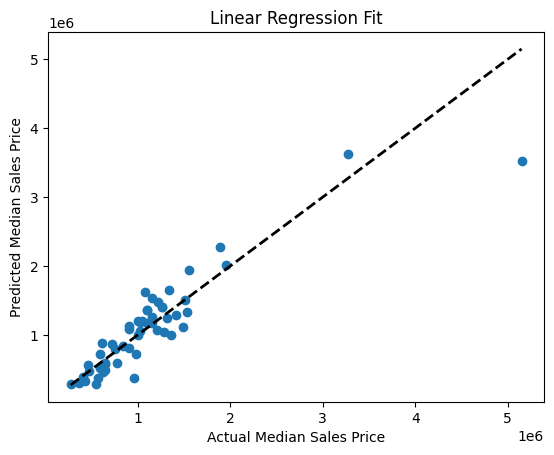

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     35.58
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.08e-15
Time:                        01:49:48   Log-Likelihood:                -745.88
No. Observations:                  53   AIC:                             1506.
Df Residuals:                      46   BIC:                             1520.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.597e+04   2

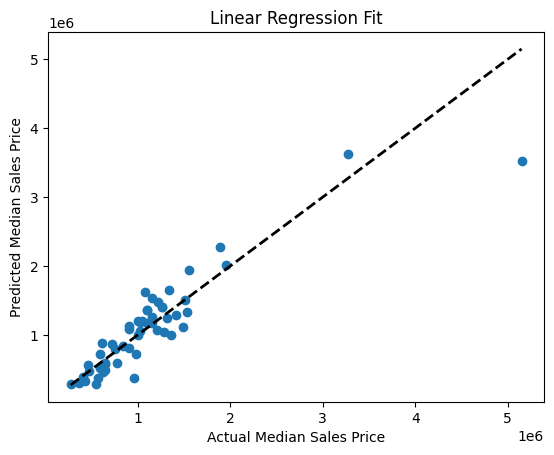

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     45.52
Date:                Mon, 13 May 2024   Prob (F-statistic):           9.99e-18
Time:                        01:49:48   Log-Likelihood:                -717.58
No. Observations:                  53   AIC:                             1449.
Df Residuals:                      46   BIC:                             1463.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -9.69e+05   1

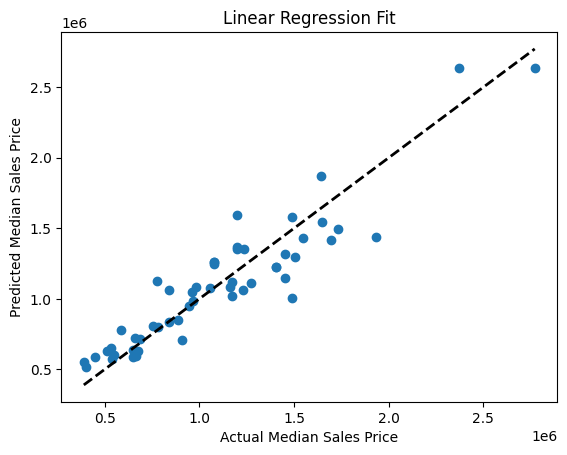

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     32.46
Date:                Mon, 13 May 2024   Prob (F-statistic):           5.88e-15
Time:                        01:49:49   Log-Likelihood:                -727.01
No. Observations:                  53   AIC:                             1468.
Df Residuals:                      46   BIC:                             1482.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.066e+05   1

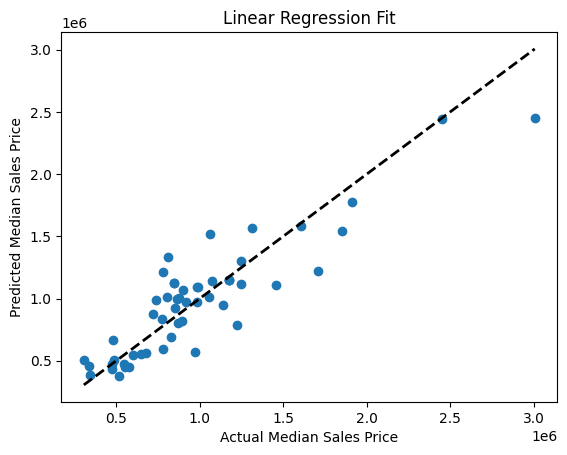

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     31.06
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.31e-14
Time:                        01:49:49   Log-Likelihood:                -733.57
No. Observations:                  53   AIC:                             1481.
Df Residuals:                      46   BIC:                             1495.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6.736e+05    

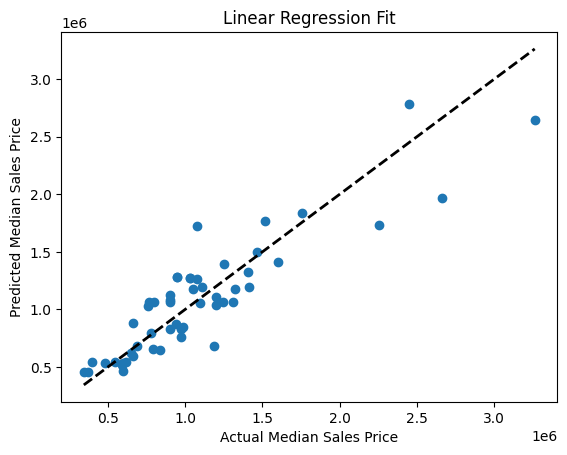

                            OLS Regression Results                            
Dep. Variable:       MedianSalesPrice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     35.01
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.46e-15
Time:                        01:49:49   Log-Likelihood:                -729.40
No. Observations:                  53   AIC:                             1473.
Df Residuals:                      46   BIC:                             1487.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.372e+06   1

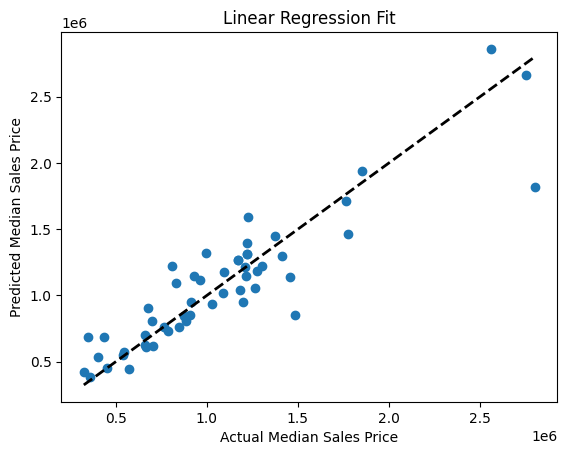

In [ ]:
linear_MSEs = []
linear_norms = []
for i in range(10):
  new_df = build_df(df1, df2, df3, df4, df5, df6, random.randint(161,171))

  # Select predictors (columns 1-5), response variable (column 6)
  X = new_df.iloc[:, 0:6]
  y = new_df.iloc[:, 6]
  X = sm.add_constant(X)
  model = sm.OLS(y, X.astype(float)).fit()
  print(model.summary())

  y_pred = model.predict(X)
  error = mean_squared_error(y, y_pred)

  plt.scatter(y, y_pred)
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # identity line
  plt.xlabel('Actual Median Sales Price')
  plt.ylabel('Predicted Median Sales Price')
  plt.title('Linear Regression Fit')
  plt.show()

  linear_MSEs.append(error)
  linear_norms.append(norm(y-y_pred))

In [ ]:
print(linear_MSEs)
print(linear_norms)

[61606559138.15294, 79713766317.16875, 52643114739.425674, 43737061029.74738, 98033713703.03261, 98033713703.03261, 33700188221.597847, 48100565054.06259, 61606559138.15294, 52643114739.425674]
[1806971.951725346, 2055439.0321315643, 1670354.7770427575, 1522519.0424348102, 2279426.8635472227, 2279426.8635472227, 1336454.255013873, 1596662.1270216557, 1806971.951725346, 1670354.7770427575]


The mean squared error is very high and variable among the 10 trials.

# Regularized Regression: Ridge, Lasso, NNLS

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
random.seed(4741)
train_df= build_df(df1, df2, df3, df4, df5, df6, random.randint(161,171))
X = train_df.iloc[:, 0:6]
y = train_df.iloc[:, 6]

In [ ]:
test_df = build_df(df1, df2, df3, df4, df5, df6, random.randint(161,171))
Xtest = test_df.iloc[:, 0:6]
ytest = test_df.iloc[:, 6]

In [ ]:
#alpha = .1 # regularization parameter
# Create a pipeline with StandardScaler and Ridge regression
#ridge_pipeline = Pipeline([
#    ('scaler', StandardScaler()),
#    ('ridge', Ridge(alpha=alpha))  # You can adjust the alpha parameter as needed
#])

In [ ]:
#lin = ridge_pipeline.fit(X,y)
#yhat = lin.predict(Xtest)
#yhat

array([1676126.76755754, 1044067.9563632 , 1431059.96259358,
        560041.45366354, 1351438.31683314,  605033.21154015,
       1082790.08831255,  417692.80302122, 1214235.54540544,
        273086.7495923 ,  831092.64138999, 1757753.30976352,
        742782.98619719,  383581.21559433, 2017734.20707664,
        895115.40666593,  913082.1359619 , 1060736.18345536,
        912216.45037653, 1077555.59361595, 1093677.13569418,
       2325357.97008231,  350740.80338289, 1198554.02262872,
       1508716.83677132,  322367.60264213, 1009665.47985582,
       1173036.43168012, 1245433.89906568, 2203798.99358217,
        845326.70520859, 1193296.16425998,  768253.41575042,
       1308115.97097392,  469640.8381282 , 1464430.45040914,
        707957.51147519, 1416338.06353271, 1242568.28044486,
       1204323.75003745,  488894.01364986,  265468.46050017,
        452552.98653701, 3587822.8405935 ,  628492.16483877,
        583917.77285707,  491858.45028944, 3501009.6764879 ,
       1431059.96259358,

In [ ]:
#norm(ytest-yhat)

2317447.107894567

In [ ]:
# find best model
alpha_ridge=.1
alpha_lasso=.1

w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_

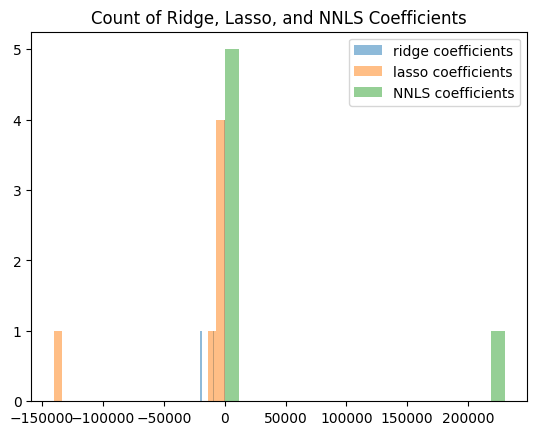

In [ ]:
plt.hist(w_ridge, label="ridge coefficients", bins=20, alpha=.5)
plt.hist(w_lasso, label="lasso coefficients", bins=20, alpha=.5)
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5)
plt.title("Count of Ridge, Lasso, and NNLS Coefficients")
plt.legend()

NNLS is the most sparse, then lasso.

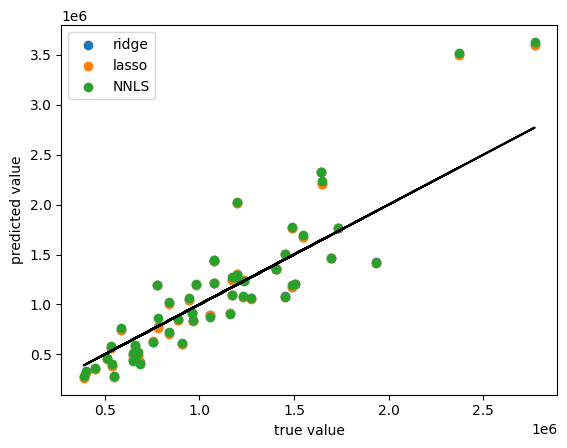

In [ ]:
yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest,color='black')
plt.scatter(ytest, yhat_ridge, label="ridge")
plt.scatter(ytest, yhat_lasso, label="lasso")
plt.scatter(ytest, yhat_nonneg, label="NNLS")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

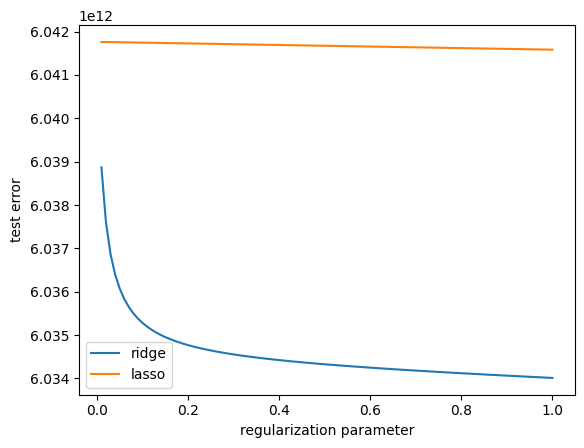

In [ ]:
# cross validate over regularization parameter alpha
ridge_error = []
lasso_error = []
alphas = np.linspace(.01,1,100)
for alpha in alphas:
    yhat_ridge = Ridge(alpha = alpha).fit(X,y).predict(Xtest)
    ridge_error.append(sum((y - yhat_ridge)**2))
    yhat_lasso = Lasso(alpha = alpha).fit(X,y).predict(Xtest)
    lasso_error.append(sum((y - yhat_lasso)**2))

plt.plot(alphas, ridge_error, label="ridge")
plt.plot(alphas, lasso_error, label="lasso")
plt.ylabel("test error")
plt.xlabel("regularization parameter")
plt.legend()

In [ ]:
print(w_ridge)
print(w_lasso)
print(w_nonneg)

print(mean_squared_error(ytest, yhat_ridge))
print(mean_squared_error(ytest, yhat_lasso))
print(mean_squared_error(ytest, yhat_nonneg))

print(norm(ytest-yhat_ridge))
print(norm(ytest-yhat_lasso))
print(norm(ytest-yhat_nonneg))

[-9.82943501e+03  7.49717188e-01  6.81727853e+01 -2.29705785e+01
 -4.48475764e+02 -2.00421272e+04]
[-1.07492754e+04  7.49182834e-01  6.88034240e+01 -2.37244170e+01
 -4.86800766e+02 -1.40474391e+05]
[0.00000000e+00 7.51834121e-01 6.64697932e+01 0.00000000e+00
 0.00000000e+00 2.30027569e+05]
101684364593.53299
101825250114.28424
104313989662.43617
2321480.416341531
2323088.086159684
2351306.3288540514


In [ ]:
print("R-squared (R2) Score for ridge:", r2_score(ytest, yhat_ridge))
print("R-squared (R2) Score for lasso:", r2_score(ytest, yhat_lasso))
print("R-squared (R2) Score for NNLS:", r2_score(ytest, yhat_nonneg))

R-squared (R2) Score for ridge: 0.565100597586113
R-squared (R2) Score for lasso: 0.5644980366218152
R-squared (R2) Score for NNLS: 0.5538538107707552


## Random Forests

In [ ]:
# Combine datasets together
com_df = build_df(df1, df2, df3, df4, df5, df6, 171)

In [ ]:
# Split data using a test-train split
X_train, X_test, y_train, y_test = train_test_split(com_df.iloc[:, 1:6], com_df.iloc[:, 6], test_size=0.30, random_state=12)

In [ ]:
# Run Random Forest model
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
predictions = rf_model.predict(X_test)

In [ ]:
# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predictions)
print("R-squared (R2) Score:", r2)

In [ ]:
# Make a forest tree visualization
estimator = rf_model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = ['MedianAskingPrice',	'MedianAskingRent',	'RecordedSalesVolume',	'DaysOnMarket',	'SaleListRatio'],
                class_names = 'Price',
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Logistic Regression

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm

df1 = pd.read_csv('medianAskingPrice_All.csv')
df2 = pd.read_csv('medianAskingRent_All.csv')
df3 = pd.read_csv('recordedSalesVolume_All.csv')
df4 = pd.read_csv('daysOnMarket_All.csv')
df5 = pd.read_csv('saleListRatio_All.csv')
df6 = pd.read_csv('medianSalesPrice_All.csv')

In [ ]:
df_logistic = build_df(df1, df2, df3, df4, df5, df6, random.randint(3,173))
print(df_logistic.shape)

(33, 7)


In [ ]:
#Combine dataframes across different months from the last year (2023-2024)
#Index for February 2024 is 171 and February 2023 is 160
start_index = 160
end_index = 171

combined_df = pd.DataFrame()

#Loop through each month's index
for month_index in range(start_index, end_index + 1):
    temp_df = build_df(df1, df2, df3, df4, df5, df6, month_index)
    combined_df = pd.concat([combined_df, temp_df])

encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(combined_df[['Borough']])
encoded_feature_names = encoder.get_feature_names_out(['Borough'])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names) #new encoded dataframe

combined_df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

#Combine the original and encoded dataframes
combined_df = pd.concat([combined_df, encoded_df], axis=1)
combined_df.drop('Borough', axis=1, inplace=True)

#Take the target selling price as the median asking price
combined_df['PriceTrend'] = combined_df.apply(
    lambda row: 'Below Ask' if row['MedianSalesPrice'] <= row['MedianAskingPrice'] else 'Above Ask',
    axis=1
)

X = combined_df.drop(['PriceTrend', 'MedianSalesPrice'], axis=1)
y = combined_df['PriceTrend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:\n", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy:
 0.848780487804878

Confusion Matrix:
 [[ 19  25]
 [  6 155]]

Classification Report:
               precision    recall  f1-score   support

   Above Ask       0.76      0.43      0.55        44
   Below Ask       0.86      0.96      0.91       161

    accuracy                           0.85       205
   macro avg       0.81      0.70      0.73       205
weighted avg       0.84      0.85      0.83       205



In [ ]:
X_with_constant = sm.add_constant(combined_df)

#Features of interest for logistic regression model
selected_cols = ['MedianAskingRent', 'RecordedSalesVolume','DaysOnMarket','SaleListRatio', 'Borough_Brooklyn', 'Borough_Queens', 'Borough_Manhattan']
X_with_constant = X_with_constant[selected_cols]
y = combined_df['PriceTrend']
y_encoded = y.replace({'Below Ask': 0, 'Above Ask': 1})

sm_model = sm.Logit(y_encoded, X_with_constant).fit(maxiter=100)
sm_model.summary()

Optimization terminated successfully.
         Current function value: 0.456344
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             PriceTrend   No. Observations:                  681
Model:                          Logit   Df Residuals:                      674
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 May 2024   Pseudo R-squ.:                  0.1832
Time:                        02:28:07   Log-Likelihood:                -310.77
converged:                       True   LL-Null:                       -380.46
Covariance Type:            nonrobust   LLR p-value:                 1.357e-27
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
MedianAskingRent       -0.0006      0.000     -3.721      0.000      -0.001      -0.000
RecordedSalesVolume     0.0004      0.000      0.807      0.420      -0.001       0.001
DaysOnMarket            0.0038      0.004      1.011      0.312      -0.004       0.011
SaleListRatio           0.5943      0.726      0.818      0.413      -0.829       2.018
Borough_Brooklyn        0.0156      0.403      0.039      0.969      -0.775       0.806
Borough_Queens          0.9616      0.395      2.437      0.015       0.188       1.735
Borough_Manhattan      -0.9612      0.506     -1.900      0.057      -1.953       0.030
=======================================================================================
"""